# Imports

In [1]:
import matplotlib.pyplot as plt
import cv2
import sys

from glob import glob
from keras.models import model_from_json
from PIL import Image

sys.path.append('EAST')
sys.path.append('scripts')
sys.path.append('image-super-resolution')
from eval import *
from helpers import *
from ISR.models import RDN

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Load image

In [3]:
# Load in test image in RGB
img = cv2.imread('data/test_img.jpg', -1)[:, :, ::-1]

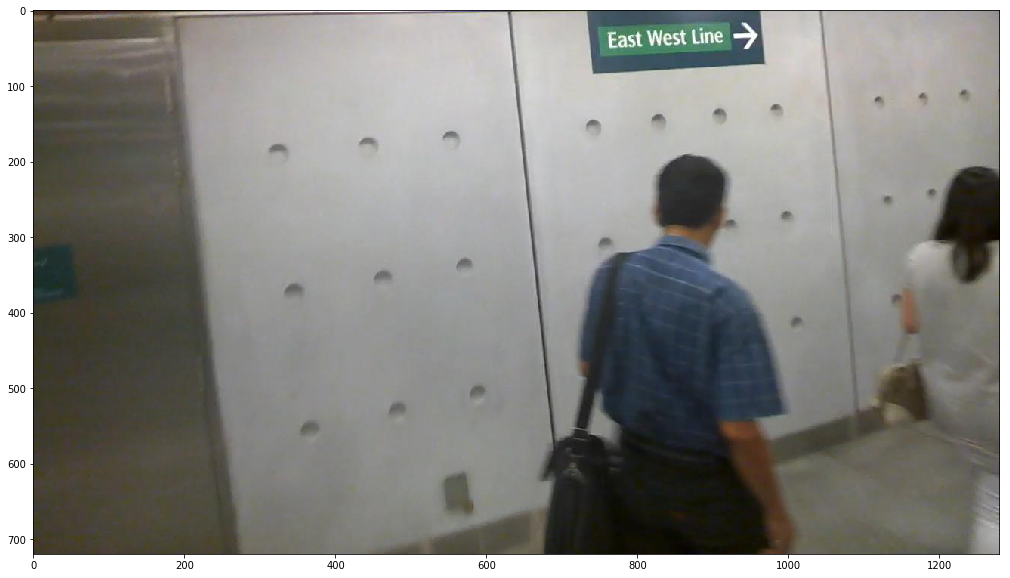

In [4]:
plt.figure(figsize=(20, 10))
plt.imshow(img)

# 1. Determine polygon surrounding text

In [5]:
with open('saved_models/east_model.json', 'r') as f:
    loaded_model_json = f.read()

east_model = model_from_json(loaded_model_json, custom_objects={'tf': tf, 'RESIZE_FACTOR': 2})
east_model.load_weights('saved_models/EAST_IC15+13_model.h5')

In [10]:
polys = run_east_model([img], east_model)

In [11]:
# Select the text box of interest
poly = np.squeeze(polys[0][0])

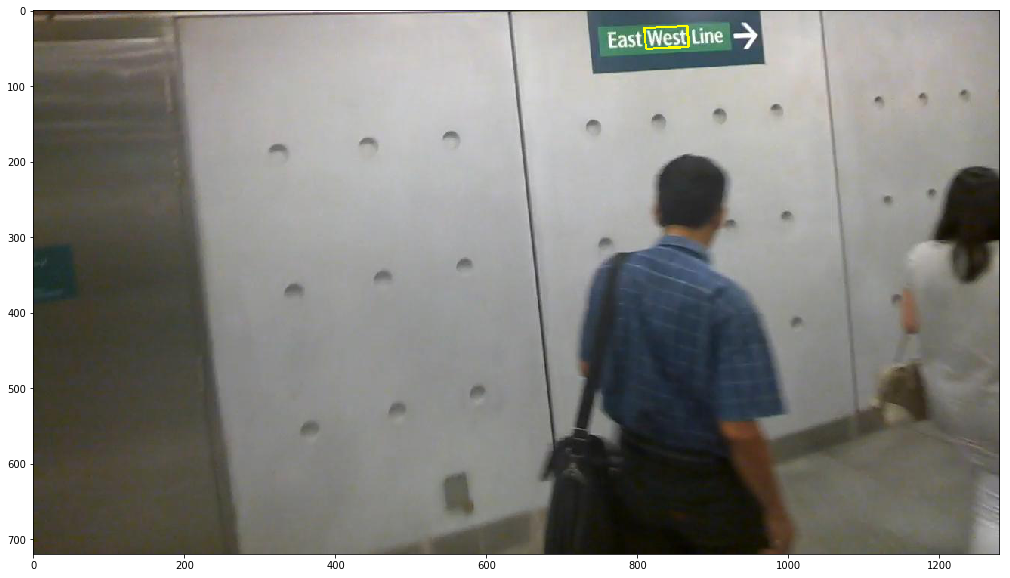

In [12]:
east_img = img.copy()
cv2.polylines(east_img, [poly.astype(np.int32).reshape((-1, 1, 2))], True, (255, 255, 0), 2)    
plt.figure(figsize=(20, 10))
plt.imshow(east_img)

# 2. Transform view of text to birds-eye perspective

In [15]:
text_img, coordinates, trans_matrix = four_point_transform(img, poly)

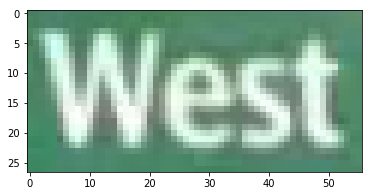

In [16]:
plt.imshow(text_img)

# 3. Increase resolution 

In [17]:
rdn = RDN(arch_params={'C':6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('image-super-resolution/weights/sample_weights/rdn-C6-D20-G64-G064-x2/ArtefactCancelling/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5')

OSError: Unable to open file (file signature not found)

In [ ]:
sr_text_img = rdn.predict(text_img)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].set_title('Low resolution image')
ax[0].imshow(text_img)

ax[1].set_title('Super resolution image')
ax[1].imshow(sr_text_img)

# 4. Prepare image of text for OCR

## 4.1 Threshold

In [ ]:
gray_text_img = cv2.cvtColor(sr_text_img, cv2.COLOR_RGB2GRAY)
thresh_text_img = cv2.adaptiveThreshold(gray_text_img, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        thresholdType=cv2.THRESH_BINARY, blockSize=77, C=3)

In [ ]:
plt.imshow(thresh_text_img, 'gray')

## 4.2 Determine if black text on white or vice versa

In [ ]:
is_black_on_white = ((np.sum(thresh_text_img[:, 0]) + np.sum(thresh_text_img[0, :]) + 
                      np.sum(thresh_text_img[:, -1]) + np.sum(thresh_text_img[-1, :])) 
                     / (2 * thresh_text_img.shape[0] + 2 * thresh_text_img.shape[1])) > 255 / 2

print('The {} text is on a {} background.'.format('black' if is_black_on_white else 'white', 
                                                 'white' if is_black_on_white else 'black'))

## 4.3 Filter out noise

In [ ]:
blob_threshold = 50
labeled_text_img, num_objs = ndimage.label(
    thresh_text_img < blob_threshold) if is_black_on_white else ndimage.label(thresh_text_img > blob_threshold)

In [ ]:
plt.imshow(labeled_text_img, 'jet')

In [ ]:
labeled_text_img

In [ ]:
masks = [(labeled_text_img == idx_obj) for idx_obj in range(num_objs + 1)]

In [ ]:
# remove masked background
max_value = max([np.sum(mask) for mask in masks])
masks_without_back = [mask for mask in masks if np.sum(mask) != max_value]

In [ ]:
masks[0].shape[0] * masks[0].shape[1]

In [ ]:
masks[1].shape[0] * masks[1].shape[1] * 0.005

In [ ]:
 # Remove small blobs 
filter_threshold = masks[0].shape[0] * masks[0].shape[1] * 0.005
print('Every blob having less than {} pixels will be filtered out.'.format(filter_threshold))
avg_pixels = np.sum(masks_without_back) / len(masks_without_back)
filtered_masks = [mask for mask in masks_without_back if np.sum(mask) > filter_threshold]

In [ ]:
filtered_text_img = (sum(filtered_masks) * 255).astype('uint8')

In [ ]:
plt.imshow(filtered_text_img, 'gray')

## 4.4 Increase canvas size

In [ ]:
canvas_factor = 0.2
bigger_text_img = cv2.copyMakeBorder(filtered_text_img, 
                                     top=int(filtered_text_img.shape[0]*canvas_factor), 
                                     bottom=int(filtered_text_img.shape[0]*canvas_factor), 
                                     left=int(filtered_text_img.shape[1]*canvas_factor),
                                     right=int(filtered_text_img.shape[1]*canvas_factor), 
                                borderType=cv2.BORDER_CONSTANT, value=0)

In [ ]:
plt.imshow(bigger_text_img, 'gray')

## 4.5 Invert colors to get black on white image

In [ ]:
inv_text_img = np.invert(bigger_text_img)

In [ ]:
plt.imshow(inv_text_img, 'gray')

## 4.6 Thin out the characters by dilating the image

In [ ]:
kernel_size = 2
dilated_text_img = dilate_img(inv_text_img, kernel_size=kernel_size, iterations=1)

In [ ]:
plt.imshow(dilated_text_img, 'gray')

# 5. Read text using pytesseract OCR

In [ ]:
whitelist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
ocr = get_ocr_data(dilated_text_img, whitelist=whitelist)
ocr

## 5.1 Filter results based on the confidence of the OCR

In [ ]:
# Filter the results of the OCR based on the confidence levels
conf_threshold = 70
filtered_ocr = filter_ocr_result(ocr, threshold=conf_threshold)
filtered_ocr

## 5.2 Get the exact position of the text using the result from the OCR

In [ ]:
reversed_polys = reverse_ocr_polys(
    (text_img, coordinates, trans_matrix), sr_text_img.shape, filtered_ocr, canvas_factor)

In [ ]:
ocr_img = east_img.copy()

for idx_poly, (poly, text, conf) in enumerate(zip(reversed_polys, filtered_ocr['text'], filtered_ocr['conf'])):
    cv2.polylines(ocr_img, [poly.reshape((-1, 1, 2))], True, (0, 255, 0), 2)
    cv2.putText(ocr_img, '{} {}%'.format(text, conf), tuple(poly[2] + 15), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(ocr_img)